In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.svm import SVR

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Objectif

Je veux créer un modèle de Machine Learning à predire la consommation électrique prévue pour la semaine à venir.

La consommation électrique j'ai utilisé est `Global_active_power`.

# charger les données

In [2]:
day_df = pd.read_csv('../data/output/day_cleaned_household_power_consumption.csv', header=0, 
                    infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# diviser un ensemble de données en ensembles train / validation

Je vais utiliser les données des trois premières années pour l'entrainement du modèle et la dernière année pour l'évaluation du modèle.

Je veux que les données d'un ensemble de données seront divisées en semaines. Ce sont des semaines qui commencent un dimanche et se terminent un samedi. Donc, je laisse tomber le premier jour qui est Samedi, et la dernière semaine sans Samedi.

In [3]:
def train_valid_diviser(values):
    '''
    diviser un ensemble de données en ensembles train / test par années
    
    Parameters:
    -- values - un np.array avec 2 dimensions
    '''
    # divisées par années
    train, valid = values[1:-328], values[-328:-6]
    return train, valid

In [4]:
train, valid = train_valid_diviser(day_df.values)

Maintenant, je prends `Global_active_power` qui est dans la première colonne.

In [5]:
train_conso = train[:,0]
valid_conso = valid[:,0]

# créer le modèle

J'applique l'algo `Recursive Multi-Step Forecasting`. En gros, elle utilise le modèle fait une prédiction pour un pas de temps, et elle prend cette prédiction comme les donées pour faire la prochaine prédiction dans un pas de temps suivant. Ce processus est répété jusqu'à ce que le nombre d'étapes souhaité ait été prévu.

Ici, un pas de temps est une semaine. Le modèle est un modèle supervisé.

## transformer les données

Tout d'abord, il faut transformer les données dans deux parties, `feature` et `target`, pour entrainer le modèle. Dans Machine Learning, `feature` est les données pour entrainer le modèle, `target` est le données qu'on veut prédire.

Dans ce projet, `feature` est les consommations dans un pas de temps, `target` est la consommation dans le jour suivant. Par exemple, si je prends les consommations de Dimanche à Samedi comme `feature`, alors le prochain Dimanche est `target`.

In [6]:
def feature_target_split(data, stride = 7):
    '''
    transformer les donnéés dans 2 parties
    
    Parameters:
    -- data - la conso, 1 dimension
    -- slide - nombre de jour choisi pour créer feature. Une samaine (7) par defaut
    '''
    feature = []
    target = []
    
    i_start = 0
    for i in range(len(data)):
        i_end = i_start + stride
        if i_end < len(data):
            feature.append(data[i_start:i_end])
            target.append(data[i_end])
            i_start += 1
    
    return np.array(feature), np.array(target)

In [7]:
train_feature, train_target = feature_target_split(train_conso)

## construire le modèle pour un pas du temps

Dans cette partie, je simplement ajoute 2 couches avant le modèle de Machine Learning. Un couche est pour standardiser les données. La sortie est central réduit. La couche suivant est pour normaliser les données. Elle met les données entre 0 et 1.

Le modèle de machine learning que je choisis est `Regression Lineair`. Il est simple et interprétable. On peut aussi jouer avec les autre modèles linéaires ou non-linéaires.

In [8]:
def create_step_model(model):
    '''
    ajouter un couche de standardisation et un couche de normalisation avant le modèle de Machine Learning
    '''
    steps = []
    steps.append(('standardize', StandardScaler()))
    steps.append(('normalize', MinMaxScaler()))
    steps.append(('model', model))
    
    step_model = Pipeline(steps=steps)
    return step_model

## forcast

J'utilse le modèle que j'ai créé pour réaliser l'algo `Recursive Multi-Step Forecasting`. Je prédis la consommation de la semaine suivante.

In [9]:
def recursive_multi_step_forecasting(model, feature):
    '''
    réaliser l'algo Recursive Multi-Step Forecasting
    
    Parameters:
    -- model - le modèle d'un pas du temps
    -- feature - les features qui creéent le modèle d'un pas du temps
    '''
    pred_sequence = []
    history = list(feature)
    stride = len(feature)
    
    for j in range(stride):
        X = np.array(history[-stride:]).reshape(1, stride)
        pred = model.predict(X)[0]
        pred_sequence.append(pred)
        # ajouter la prediction dans les données entrées
        history.append(pred)
    return np.array(pred_sequence)

## créer le modèle final

A la fin, je mets touts les codes dans une fonction pour faire la prediction de la consommation de la dernier année. Dans la fonction, chaque itération predit une semaine de la consommation.

In [10]:
def model_prediction(model, train, valid, stride=7):
    '''
    La fonction utilise l'ensemble de train à entraîner le modèle,
    et l'ensemble de validation à prédire

    Parametres:
    -- model - le modèle de Sklearn
    -- train, valid - les données, np.array avec 1 dimension
    -- stride - la période de la prédiction 
    '''
    history = list(train)
    pred = []
    
    # train the model
    train_x, train_y = feature_target_split(history, stride)
    step_model = create_step_model(model)
    step_model.fit(train_x, train_y)
    input_data = train_x[-1, :]
    
    for i in range(0,len(valid),stride):
        pred_sequence = recursive_multi_step_forecasting(step_model, input_data)
        pred.append(pred_sequence)
        # charger les données d'une semaine prochaine pour faire la prédiction suivante
        input_data = valid[i:i+stride]
    
    return step_model, np.array(pred).flatten()

In [11]:
step_model, pred = model_prediction(LinearRegression(), train_conso, valid_conso, stride=7)

In [12]:
with open('../data/output/step_model.pkl', 'wb') as f:
    pickle.dump(step_model, f)

# évaluer le modèle

J'affiche la prédiction et la consommation réelle dans la dernier année. On voit que elles sont proche. 

Mais, la prédiction sont retardée par rapport à la consommation. Par example, la consommation descend plus tôt que la prédiction dans Août. Je crois le fait que la prédiction est basé sur les données une semaine pose ce problème. Si on choisit un mois de données, les deux courbes vont être plus proche. 

In [13]:
valid_df = day_df[-328:-6].copy()
valid_df['GAP_pred'] = pred

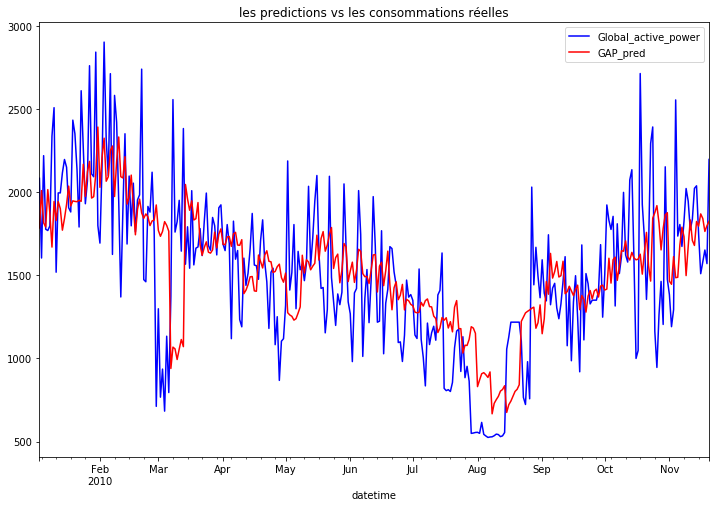

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = valid_df.Global_active_power.plot(color='b', legend=True)
ax = valid_df.GAP_pred.plot(color='r', legend=True)
ax.title.set_text('les predictions vs les consommations réelles')
fig.savefig('../data/output/images/pred_year.png')

J'affiche la même chose dans la dernière semaine. On voit que le modèle est mal à predire la consommation de Samedi et Dimanche.

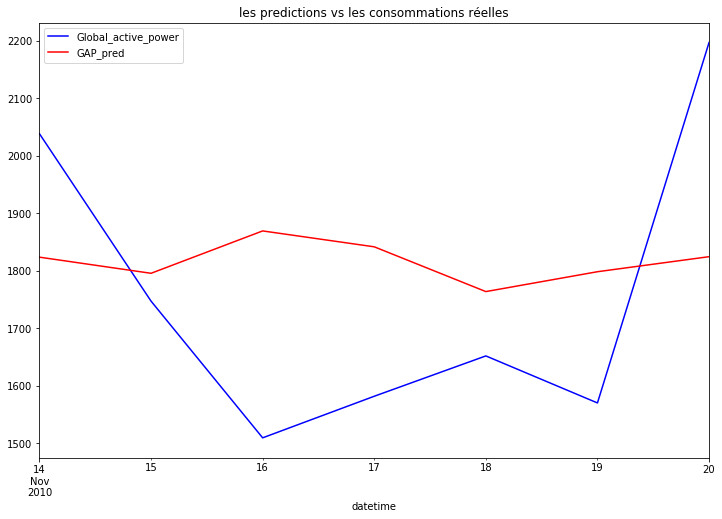

In [15]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = valid_df.Global_active_power[-7:].plot(color='b', legend=True)
ax = valid_df.GAP_pred[-7:].plot(color='r', legend=True)
ax.title.set_text('les predictions vs les consommations réelles')
fig.savefig('../data/output/images/pred_week.png')

In [16]:
input_data = valid_conso[-7:]
pred_sequence = recursive_multi_step_forecasting(step_model, input_data)

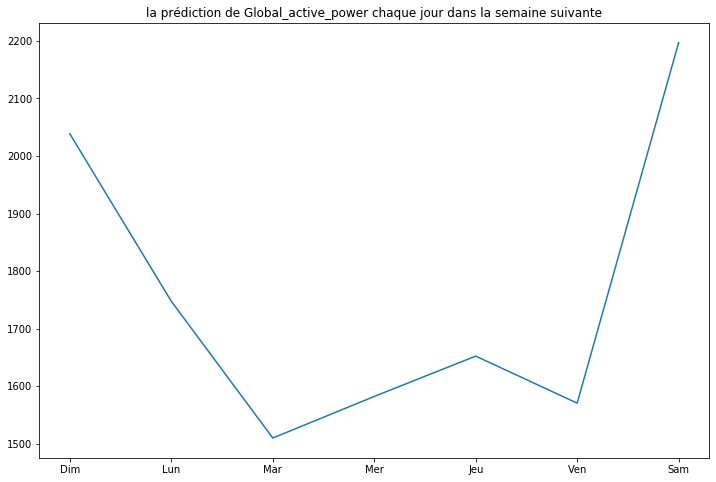

In [19]:
x_labels = ['Dim', 'Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam']

fig, ax = plt.subplots(figsize = (12, 8))
plt.title('la prédiction de Global_active_power chaque jour dans la semaine suivante')
plt.xticks(list(range(7)),x_labels)
plt.plot(input_data)
plt.savefig('../data/output/images/gap_pred.png')